In [1]:
import open3d as o3d
import numpy as np
import os
import glob
import pandas as pd
import pymeshlab as pml
import time
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys
sys.path.append('../preprocessing')
from viz import viz_mesh

In [3]:
def o3d_to_pml(mesh):
    tmp_file_name = "temp.obj"
    o3d.io.write_triangle_mesh(tmp_file_name, mesh)
    # if not os.path.exists(tmp_file_name):
    #     print(f"File '{tmp_file_name}' doesn't exist. Waiting for 1 second...")
    #     time.sleep(1)    
    mesh_pml = pml.MeshSet()
    mesh_pml.load_new_mesh(tmp_file_name)
    os.remove(tmp_file_name)
    return mesh_pml

In [4]:
def pml_to_o3d(mesh):
    tmp_file_name = "temp.obj"

    mesh.save_current_mesh(tmp_file_name)
    # if not os.path.exists(tmp_file_name):
    #     print(f"File '{tmp_file_name}' doesn't exist. Waiting for 1 second...")
    #     time.sleep(1)   
    mesh_o3d = o3d.io.read_triangle_mesh(tmp_file_name)
    os.remove(tmp_file_name)
    return mesh_o3d

In [6]:
path = "../resampledPML2/Starship/m1358.obj"
# path = "../resampledPML/Biplane/D00069.obj"

# path = "../database\Drum\D00115.obj"
mesh = o3d.io.read_triangle_mesh(path)
# np.asarray(mesh.vertices)[:,1] = 0

In [4]:
# o3d.visualization.draw_geometries([mesh], width=1280, height=720, mesh_show_back_face=True,  mesh_show_wireframe=True)

In [2]:
# viz_mesh(mesh, vis_option="smoothshade")

In [10]:
mesh = pml.MeshSet()
mesh.load_new_mesh(path)


In [11]:
mesh.meshing_isotropic_explicit_remeshing(targetlen=pml.AbsoluteValue(0.001), iterations=3)


In [12]:
mesh = pml_to_o3d(mesh)

In [11]:
isinstance(mesh, pml.MeshSet)

True

In [5]:
import numpy as np

# # Create a 3D point cloud as an example
# point_cloud = np.array([[1.0, 2.0, 3.0],
#                         [4.0, 5.0, 6.0],
#                         [7.0, 8.0, 9.0],
#                         [2.0, 3.0, 1.0]])

def voxelgrid2d(mesh, projection_plane='XY', size=100):

    if isinstance(mesh, pml.MeshSet):
        mesh = pml_to_o3d(mesh)

    point_cloud = np.asarray(mesh.vertices)
    # Define a projection plane (e.g., the XY plane)
    # projection_plane = 'XY'  # You can also use 'XZ' or 'YZ'

    # Define voxelization parameters
    voxel_size = 1/(size-1)  # Adjust as needed

    # Project the 3D points onto the 2D plane
    if projection_plane == 'XY':
        projected_points = point_cloud[:, :2]  # Project onto the XY plane
    elif projection_plane == 'XZ':
        projected_points = point_cloud[:, [0, 2]]  # Project onto the XZ plane
    elif projection_plane == 'YZ':
        projected_points = point_cloud[:, 1:]  # Project onto the YZ plane

    # Calculate the grid size based on the projected points
    min_coords = np.min(projected_points, axis=0)
    max_coords = np.max(projected_points, axis=0)
    grid_size = (int((max_coords[0] - min_coords[0]) / voxel_size), int((max_coords[1] - min_coords[1]) / voxel_size))
    grid_size = (size,size)

    # Create an empty voxel grid
    voxel_grid = np.zeros(grid_size, dtype=int)

    # Iterate through the projected points and populate the voxel grid
    for point in projected_points:
        voxel_x, voxel_y = int((point[0] - min_coords[0]) / voxel_size), int((point[1] - min_coords[1]) / voxel_size)
        voxel_grid[voxel_x, voxel_y] = 1

    # Now, voxel_grid contains the 2D voxelization of the 3D point cloud
    return voxel_grid


In [8]:
plt.imshow(voxelgrid2d(mesh,projection_plane="XY"), cmap='gray')

NameError: name 'mesh' is not defined

In [25]:
voxelgrid2d(mesh,projection_plane="XY").shape

(100, 100)

In [6]:
run_2dvox = True

if run_2dvox:

    dbpath = r"../resampledPML2/"
    data = []
    for class_folder in os.listdir(dbpath)[18:]:
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                log = open("./log_cnn.txt", "a")

                # try:
                mesh = pml.MeshSet()
                mesh.load_new_mesh(obj_file_path)
                voxel_grids = []
                print(f"Converting {obj_file_path}...")
                for projection_plane in ["XY", "XZ", "YZ"]:
                    voxel_grid = voxelgrid2d(mesh,projection_plane=projection_plane)
                    voxel_grids.append(voxel_grid)
                    if not os.path.exists(f"../resampledCNN/{class_name}"):
                        os.makedirs(f"../resampledCNN/{class_name}")
                    plt.imsave(f"../resampledCNN/{class_name}/{os.path.basename(obj_file_path)[:-4]}_{projection_plane}.png", voxel_grid, cmap='gray')
                    # Save the 3 projection planes together with the obj name and class name in  a array or pd df
                data.append({'Object Name': os.path.basename(obj_file_path)[:-4], 'Class Name': class_name, 'XY': voxel_grids[0], 'XZ': voxel_grids[1], 'YZ': voxel_grids[2]})


                # except:
                #     print(f"Failed to convert {obj_file_path}", file=log)
                #     print(f"Failed to convert {obj_file_path}")

                log.close()


Converting ../resampledPML2/Cup\D00035.obj...
Converting ../resampledPML2/Cup\D00067.obj...
Converting ../resampledPML2/Cup\D00174.obj...
Converting ../resampledPML2/Cup\D00206.obj...
Converting ../resampledPML2/Cup\D00214.obj...
Converting ../resampledPML2/Cup\D00270.obj...
Converting ../resampledPML2/Cup\D00328.obj...
Converting ../resampledPML2/Cup\D00355.obj...
Converting ../resampledPML2/Cup\D00363.obj...
Converting ../resampledPML2/Cup\D00457.obj...
Converting ../resampledPML2/Cup\D00463.obj...
Converting ../resampledPML2/Cup\D00519.obj...
Converting ../resampledPML2/Cup\D00550.obj...
Converting ../resampledPML2/Cup\D00587.obj...
Converting ../resampledPML2/Cup\D00638.obj...
Converting ../resampledPML2/Cup\D00642.obj...
Converting ../resampledPML2/Cup\D00738.obj...
Converting ../resampledPML2/Cup\D00843.obj...
Converting ../resampledPML2/Cup\D00874.obj...
Converting ../resampledPML2/Cup\D00882.obj...
Converting ../resampledPML2/Cup\m494.obj...
Converting ../resampledPML2/Cup\m495

In [7]:
olddata = data

In [8]:
df = pd.DataFrame(data)

In [9]:
df

,Object Name,Class Name,XY,XZ,YZ
0,D00035,Cup,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,D00067,Cup,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,D00174,Cup,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,D00206,Cup,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,D00214,Cup,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
1886,D00687,WheelChair,"[[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1887,D00720,WheelChair,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1888,D00782,WheelChair,"[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1889,D00821,WheelChair,"[[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


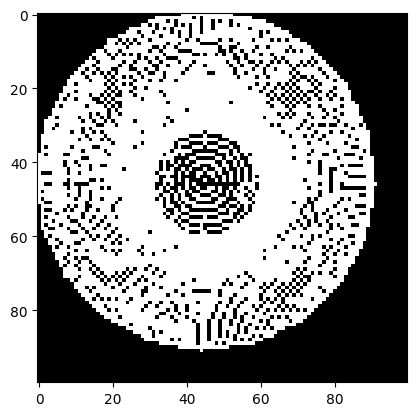

In [34]:
plt.imshow(df["YZ"][0], cmap='gray')

In [ ]:
imgspath = "../resampledCNN/"

for class_folder in os.listdir(imgspath):
    

In [21]:
import os
import pandas as pd
from glob import glob
import cv2
# Define the root directory where your data is located
root_dir = '../resampledCNN'

# Initialize empty lists to store the data
object_names = []
class_names = []
xy_images = []
xz_images = []
yz_images = []

# Iterate through the directories
for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    if os.path.isdir(class_path):
        for object_dir in os.listdir(class_path):
            object_name = object_dir
            object_path = os.path.join(class_path, object_dir)
            
            # Get paths to the XY, XZ, and YZ images for the object
            # xy_image = glob(os.path.join(object_path, f"{object_name}_XY.png"))
            # xz_image = glob(os.path.join(object_path, f"{object_name}_XZ.png"))
            # yz_image = glob(os.path.join(object_path, f"{object_name}_YZ.png"))
            
            # Append data to the lists
            # if xy_image and xz_image and yz_image:
            if object_path[-6:-4] == "XY":
                xy_image = object_path
            if object_path[-6:-4] == "XZ":
                xz_image = object_path
            if object_path[-6:-4] == "YZ":
                yz_image = object_path

            if xy_image and xz_image and yz_image:    

                object_names.append(object_name[:-7])
                class_names.append(class_dir)
                xy_images.append(cv2.imread(xy_image, cv2.IMREAD_GRAYSCALE))
                xz_images.append(cv2.imread(xz_image, cv2.IMREAD_GRAYSCALE))
                yz_images.append(cv2.imread(yz_image, cv2.IMREAD_GRAYSCALE))
                xy_image, xz_image, yz_image = None, None, None

# Create a DataFrame
data = {
    'Object Name': object_names,
    'Class Name': class_names,
    'XY': xy_images,
    'XZ': xz_images,
    'YZ': yz_images
}

df2 = pd.DataFrame(data)

# Optional: Display the first few rows of the DataFrame
print(df2.head())


In [ ]:
df2

,Object Name,Class Name,XY,XZ,YZ
0,m1337_,AircraftBuoyant,None,None,None
1,m1338_,AircraftBuoyant,None,None,None
2,m1339_,AircraftBuoyant,None,None,None
3,m1340_,AircraftBuoyant,None,None,None
4,m1341_,AircraftBuoyant,None,None,None
...,...,...,...,...,...
2462,D00687_,WheelChair,None,None,None
2463,D00720_,WheelChair,None,None,None
2464,D00782_,WheelChair,None,None,None
2465,D00821_,WheelChair,None,None,None


In [12]:
df2

,Object Name,Class Name,XY,XZ,YZ
